# <center>Projeto Aprovação de Emprestimos<center>

Iniciamos importando os pacotes necessários para o projeto

In [350]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# importamos apenas os métodos necessarios do pacote sklearn, utilizados para o processo de machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# estilização dos plots
plt.style.use('ggplot')

Em seguida, vamos carregar os dados necessários que estão disponiveis no arquivo csv fornecido junto desse notebook.

In [351]:
df = pd.read_csv('train.csv')

Esse dataset não possui uma documentação, então temos de avaliar cada coluna para descobrir sua utilidade através do nome. Além disso, é sempre bom efetuar as funções básicas de visualização dos dados para interpeta-los e confirmar que está tudo ok com o dataset:

In [352]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1.0,No,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,1.0,Yes,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,1.0,Yes,0.0,1,1.0,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,1.0,Yes,0.0,0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,1.0,No,0.0,1,0.0,6000,0.0,141.0,360.0,1.0,Urban,Y


In [353]:
df.dtypes

Loan_ID               object
Gender               float64
Married               object
Dependents           float64
Education              int64
Self_Employed        float64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Como pode ver abaixo, a função describe não possui uma eficiência boa com datasets de treinamento, pois a maior parte das colunas se torna quantitativa. Porém quando conhecemos as colunas, podemos avaliar os dados relevantes com ele mesmo assim.

In [354]:
df.describe()

,Gender,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,592.000000,614.000000,564.000000
mean,0.817590,0.744300,0.781759,0.133550,5403.459283,1621.245798,146.412162,342.410423,0.842199
std,0.386497,1.009623,0.413389,0.340446,6109.041673,2926.248369,85.587325,64.428629,0.364878
min,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000
50%,1.000000,0.000000,1.000000,0.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,5795.000000,2297.250000,168.000000,360.000000,1.000000
max,1.000000,3.000000,1.000000,1.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000


É importante também saber o tamanho da amostra utilizando o método shape, que nos mostra o numero de linhas e colunas:

In [355]:
df.shape

(614, 13)

Aparentemente a formatação e tipo de dado estão ok, com algumas exceções, como *Gender*, *Property_Area* e *Loan_Status*, que não está em forma númerica.  

Vamos prosseguir com o estudo do dataset, avaliando a coluna Loan_Status, para saber o tamanho da amostra que foi aprovado.

In [356]:
# Verificar os elementos distintos da coluna Loan_Status
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

Vamos avaliar os emprestimos, correlacionando ele com a renda do requisitante.

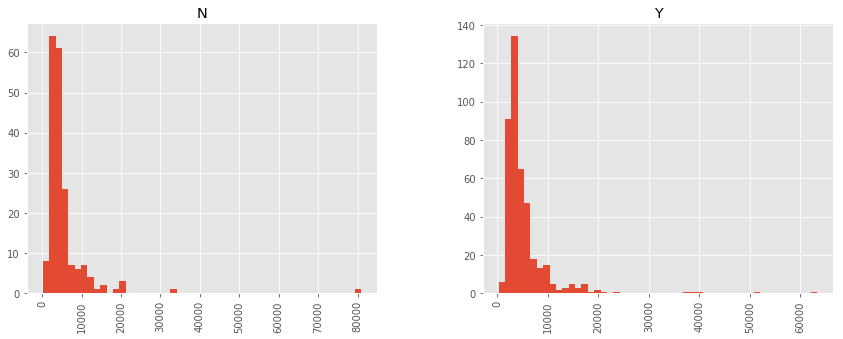

In [357]:
# Visualizar a correlação de renda e aprovação
# parametro bins define quantidade de grupos de contagem
df[['Loan_Status', 'ApplicantIncome']].hist(bins=50, figsize=(14,5),by='Loan_Status') 
plt.show()

Podemos ver que a maior parte dos pedidos vem de renda menor que 10 mil.  

Vamos agora conferir como estão distribuidos os pedidos com co-requisitantes.  

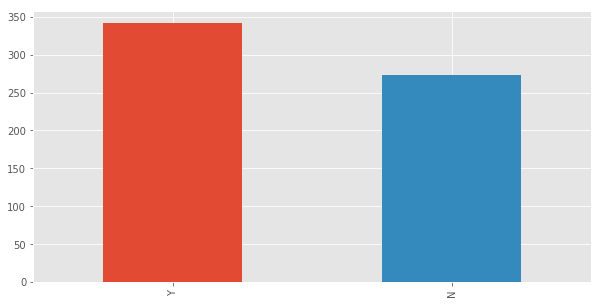

In [358]:
# lambda é uma função que executa uma tarefa especifica, como se fosse uma "função descartavel"
# apply é um método que executa uma função especifica individualmente em cada linha do dataset selecionado.
coapplicants = df['CoapplicantIncome'].apply(lambda x: 'N' if x == 0 else 'Y')
coapplicants.value_counts().plot(kind='bar', figsize=(10,5))
plt.show()

A maior parte dos empréstimos aprovados tiveram co-requisitantes. Vamos analisar a correlação disso com a aprovação mais abaixo.

Esses passos foram para demonstrar que o processo de analise exploratória faz parte do processo de desenvolvimento para soluções em machinel learning. Vamos seguir agora com o processo de feature engineering.

## Feature Engineering

Primeiro, vamos remover a coluna Loan_ID, ela não será necessária.

In [359]:
# Parametro inplace faz atribuição da mudança à variavel do dataframe
df.drop('Loan_ID', axis=1, inplace=True) # axis: 0 é remoção nível linha, 1 é nível coluna

df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,No,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,Urban,Y
1,1.0,Yes,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,Rural,N
2,1.0,Yes,0.0,1,1.0,3000,0.0,66.0,360.0,1.0,Urban,Y
3,1.0,Yes,0.0,0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,1.0,No,0.0,1,0.0,6000,0.0,141.0,360.0,1.0,Urban,Y


Em seguida, vamos renomear as colunas para melhor identificação.

In [360]:
# lista as colunas para que possamos ter mais facilidade na renomeação
df.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [361]:
# Aplicamos novos nomes nas colunas
df.columns = ['Masculino', 'Casado', 'QtdDependentes', 'Graduado', 'Empreendedor',
       'ValorRendaRequisitante', 'ValorRendaCoRequisitante', 'ValorEmprestimo',
       'DuracaoEmprestimo', 'TemHistoricoCredito', 'TipoAreaResidencia', 'EmprestimoAprovado']

O próximo passo é tornar as colunas catégoricas em númericas.

In [362]:
# Mapper com valores da coluna Casado
mapper = { 'Yes': 1, 'No':  0}

# Quantifica o valor
df['Casado'] = df['Casado'].map(mapper)

# Confere que o valor virou númerico(int ou float):
print('Tipo Coluna Casado: ' + str(df['Casado'].dtype)) #precisamos do print pois há mais códigos abaixo

# Mudamos o mapper agora para os valores da coluna EmprestimoAprovado e efetuamos o mesmo processo.
mapper = { 'Y': 1, 'N': 0 }
df['EmprestimoAprovado'] = df['EmprestimoAprovado'].map(mapper)
print('Tipo Coluna EmprestimoAprovado: ' + str(df['EmprestimoAprovado'].dtype))

df.head()

Tipo Coluna Casado: float64
Tipo Coluna EmprestimoAprovado: int64


,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,TipoAreaResidencia,EmprestimoAprovado
0,1.0,0.0,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,Urban,1
1,1.0,1.0,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,Rural,0
2,1.0,1.0,0.0,1,1.0,3000,0.0,66.0,360.0,1.0,Urban,1
3,1.0,1.0,0.0,0,0.0,2583,2358.0,120.0,360.0,1.0,Urban,1
4,1.0,0.0,0.0,1,0.0,6000,0.0,141.0,360.0,1.0,Urban,1


Vamos conferir quantos valores nulos temos no dataset:

In [363]:
df.isnull().sum().sort_values(ascending=False)

TemHistoricoCredito         50
ValorEmprestimo             22
Casado                       3
EmprestimoAprovado           0
TipoAreaResidencia           0
DuracaoEmprestimo            0
ValorRendaCoRequisitante     0
ValorRendaRequisitante       0
Empreendedor                 0
Graduado                     0
QtdDependentes               0
Masculino                    0
dtype: int64

Vamos lidar com esses dados utilizando técnicas de inputação de dados.

In [364]:
# Eliminamos as linhas com Casado Nulo, pois são poucas
df = df.dropna(subset=['Casado'])

# Preencher nulos da coluna ValorEmprestimo com a média de valores
df['ValorEmprestimo'].fillna(df['ValorEmprestimo'].mean(), inplace=True)

df.head()

,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,TipoAreaResidencia,EmprestimoAprovado
0,1.0,0.0,0.0,1,0.0,5849,0.0,146.369492,360.0,1.0,Urban,1
1,1.0,1.0,1.0,1,0.0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,1.0,1.0,0.0,1,1.0,3000,0.0,66.000000,360.0,1.0,Urban,1
3,1.0,1.0,0.0,0,0.0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,1.0,0.0,0.0,1,0.0,6000,0.0,141.000000,360.0,1.0,Urban,1


Vamos avaliar a coluna TemHistoricoCredito para decidir como preenche-la

In [365]:
df['TemHistoricoCredito'].value_counts()

1.0    472
0.0     89
Name: TemHistoricoCredito, dtype: int64

A grande maioria é 1, então podemos arriscar preencher os numeros com esse valor para conferirmos o resultado. Caso ele não seja bom podemos reavaliar essa decisão.

In [366]:
# Usamos o método index[0] no método value_counts para 
# automaticamente selecionar o primeiro valor, que é o que possui contagem maior
df['TemHistoricoCredito'].fillna(df['TemHistoricoCredito'].value_counts().index[0], inplace=True)

df.head()

,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,TipoAreaResidencia,EmprestimoAprovado
0,1.0,0.0,0.0,1,0.0,5849,0.0,146.369492,360.0,1.0,Urban,1
1,1.0,1.0,1.0,1,0.0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,1.0,1.0,0.0,1,1.0,3000,0.0,66.000000,360.0,1.0,Urban,1
3,1.0,1.0,0.0,0,0.0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,1.0,0.0,0.0,1,0.0,6000,0.0,141.000000,360.0,1.0,Urban,1


Vamos avaliar a amostra geral agora:

In [367]:
df.shape

(611, 12)

Ainda há uma coluna para ser quantificada, que é a TipoAreaResidencia.  
Começamos verificando quais seus valores unicos.

In [368]:
df['TipoAreaResidencia'].unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

Vamos utilizar a técnica **One Hot Encoding**, que significa criar uma coluna para cada valor da coluna *TipoAreaResidencia*, transformando essa informação em três colunas booleanas (Sim ou Não)

In [369]:
# método get_dummies executa a técnica one-hot encoding
df = pd.get_dummies(df, columns=['TipoAreaResidencia'])

df.head()

,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,EmprestimoAprovado,TipoAreaResidencia_Rural,TipoAreaResidencia_Semiurban,TipoAreaResidencia_Urban
0,1.0,0.0,0.0,1,0.0,5849,0.0,146.369492,360.0,1.0,1,0,0,1
1,1.0,1.0,1.0,1,0.0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0
2,1.0,1.0,0.0,1,1.0,3000,0.0,66.000000,360.0,1.0,1,0,0,1
3,1.0,1.0,0.0,0,0.0,2583,2358.0,120.000000,360.0,1.0,1,0,0,1
4,1.0,0.0,0.0,1,0.0,6000,0.0,141.000000,360.0,1.0,1,0,0,1


Vamos avaliar a correlação das colunas

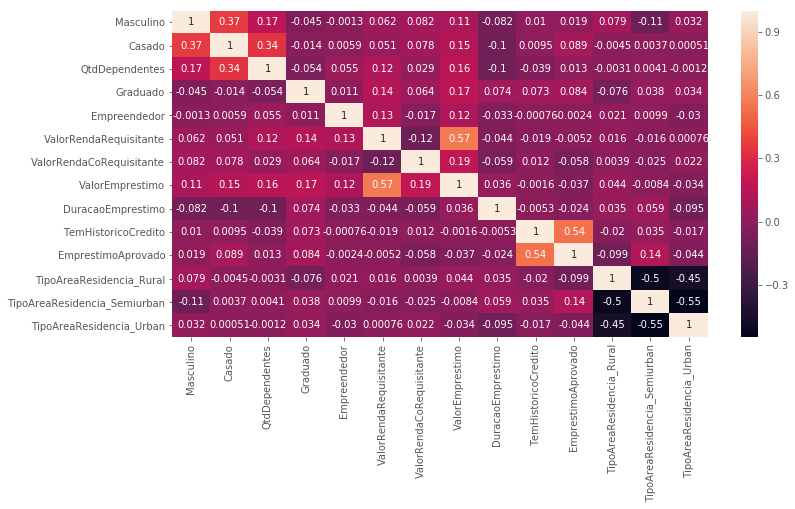

In [370]:
plt.figure(figsize=(12,6))

sns.heatmap(df.corr(), annot=True)
plt.show()

Quanto mais escuro a cor, ou quanto mais clara, maior a correlação (respectivamente, inversa e direta).  

Podemos verificar uma correlação direta moderada entre *EmprestimoAprovado* e *TemHistóricoCredito*, assim como entre *ValorEmprestimo* e *RendaRequisitante*.  

Também existe uma correlação entre *EmprestimoAprovado* e *TipoAreaResidencia_Semiurban*, porém é muito fraca.

Veja imagem abaixo como referência para a força da correlação:
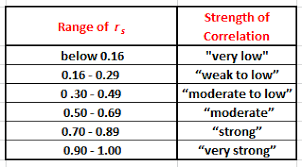

Vamos adicionar uma coluna para representar a soma da renda do requisitante e do co-requisitante.

In [371]:
df['ValorRendaTotal'] = df['ValorRendaRequisitante'] + df['ValorRendaCoRequisitante']

df.head()

,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,EmprestimoAprovado,TipoAreaResidencia_Rural,TipoAreaResidencia_Semiurban,TipoAreaResidencia_Urban,ValorRendaTotal
0,1.0,0.0,0.0,1,0.0,5849,0.0,146.369492,360.0,1.0,1,0,0,1,5849.0
1,1.0,1.0,1.0,1,0.0,4583,1508.0,128.000000,360.0,1.0,0,1,0,0,6091.0
2,1.0,1.0,0.0,1,1.0,3000,0.0,66.000000,360.0,1.0,1,0,0,1,3000.0
3,1.0,1.0,0.0,0,0.0,2583,2358.0,120.000000,360.0,1.0,1,0,0,1,4941.0
4,1.0,0.0,0.0,1,0.0,6000,0.0,141.000000,360.0,1.0,1,0,0,1,6000.0


É importante também normalizarmos os valores quantitativos como as colunas ValorRenda*.  
Uma técnca para normalizar esses valores é através do log de 10. 

In [372]:
# Calcula logaritimo das colunas
df['ValorRendaRequisitante'] = np.log(df['ValorRendaRequisitante'])

# Como CoRequisitante possui zeros, ele irá ter problemas com o log. Para isso, definimos 0 = 1 para que o log seja zero
df.loc[df['ValorRendaCoRequisitante'] == 0, 'ValorRendaCoRequisitante'] = 1
df['ValorRendaCoRequisitante'] = np.log(df['ValorRendaCoRequisitante']) 

df['ValorRendaTotal'] = np.log(df['ValorRendaTotal'])

df.head()

,Masculino,Casado,QtdDependentes,Graduado,Empreendedor,ValorRendaRequisitante,ValorRendaCoRequisitante,ValorEmprestimo,DuracaoEmprestimo,TemHistoricoCredito,EmprestimoAprovado,TipoAreaResidencia_Rural,TipoAreaResidencia_Semiurban,TipoAreaResidencia_Urban,ValorRendaTotal
0,1.0,0.0,0.0,1,0.0,8.674026,0.000000,146.369492,360.0,1.0,1,0,0,1,8.674026
1,1.0,1.0,1.0,1,0.0,8.430109,7.318540,128.000000,360.0,1.0,0,1,0,0,8.714568
2,1.0,1.0,0.0,1,1.0,8.006368,0.000000,66.000000,360.0,1.0,1,0,0,1,8.006368
3,1.0,1.0,0.0,0,0.0,7.856707,7.765569,120.000000,360.0,1.0,1,0,0,1,8.505323
4,1.0,0.0,0.0,1,0.0,8.699515,0.000000,141.000000,360.0,1.0,1,0,0,1,8.699515


O próximo passo é definir quais colunas são features e qual a coluna que queremos prever.

In [373]:
# utilizamos X maiusculo como conveção para colunas features e y para a coluan label
X = df.drop('EmprestimoAprovado', axis=1)
y = df['EmprestimoAprovado']

Em seguida, separamos o dataset em duas partes, uma para treino e outra para testes.

In [374]:
# utilizamos o método do sklearn train_test_split para criar a separação
# A ordem é feature_train, feature_test, label_train, label_test
# O parametro test_size diz qual o tamanho do dataset será usado para teste
# O parametro random_state é um seed(semente) utilizado para randomização da separação, melhorando-a
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Agora estamos prontos para treinar o modelo. Vamos aplicar três algoritimos diferentes:  
1. Regressão Logística
2. Arvore de Decisão
3. Floresta Aleatória

In [375]:
# Regressão Logística
lr = LogisticRegression() # criado instancia de logistic regressor
lr.fit(X_train, y_train) # função fit executa o treinamento

# Abaixo os parametros da regressão:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Vamos verificar a pontuação desse treinamento e do teste.  
A pontuação utiliza a função matemática de acuracia para medir a porcentagem qeu foi acertada na predição.

In [376]:
# print do score do treinamento
print('Treinamento: {0:.2%}'.format(lr.score(X_train, y_train)))

# print do score de teste
print('Testes: {0:.2%}'.format(lr.score(X_test, y_test)))

Treinamento: 80.44%
Testes: 82.18%


Agora, utilizando o algoritimo de Arvore de Decisão.

In [377]:
dt = DecisionTreeClassifier() # inicia instancia do DecisionTreeClassifier

dt.fit(X_train, y_train) # função fit executa o treinamento

# Abaixo os parametros do treinamento:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [378]:
# print do score do treinamento
print('Treinamento: {0:.2%}'.format(dt.score(X_train, y_train)))

# print do score de teste
print('Testes: {0:.2%}'.format(dt.score(X_test, y_test)))

Treinamento: 100.00%
Testes: 72.28%


Árvores de decisão possuem problemas de overfitting, o que pode ser observado com o score do treinamento, que não possui a mesma eficiencia com dados não conhecidos.  

Para melhorar esse problema, podemos efetuar alguns parametros de configuração.

In [379]:
# max_leaf_nodes limita o numero de folhas da árvore decisória
# max_depth é um parametro que limita o numero de aprofundamento da arvore decisória
# É um processo de tentativa e erro, para encontrar o valor ideal
dt = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=8)  # encontrado o 8 como ideal por tentativa e erro

dt.fit(X_train, y_train)

# print do score do treinamento
print('Treinamento: {0:.2%}'.format(dt.score(X_train, y_train)))

# print do score de teste
print('Testes: {0:.2%}'.format(dt.score(X_test, y_test)))

Treinamento: 82.64%
Testes: 82.67%


Vamos avaliar as definições de importância para as features dada pelo classificador de árvore decisória:

In [380]:
importance = list(zip(dt.feature_importances_, X_train.columns))
importance

[(0.0, 'Masculino'),
 (0.0, 'Casado'),
 (0.0, 'QtdDependentes'),
 (0.0, 'Graduado'),
 (0.0, 'Empreendedor'),
 (0.0, 'ValorRendaRequisitante'),
 (0.026349126159428173, 'ValorRendaCoRequisitante'),
 (0.0272901663794077, 'ValorEmprestimo'),
 (0.02401532199469069, 'DuracaoEmprestimo'),
 (0.7504637213839195, 'TemHistoricoCredito'),
 (0.0, 'TipoAreaResidencia_Rural'),
 (0.06143566091030819, 'TipoAreaResidencia_Semiurban'),
 (0.0, 'TipoAreaResidencia_Urban'),
 (0.11044600317224577, 'ValorRendaTotal')]

Por último, vamos testar o algoritimo de floresta aleatória.

In [381]:
rf = RandomForestClassifier() 
rf.fit(X_train, y_train)

# print do score do treinamento
print('Treinamento: {0:.2%}'.format(rf.score(X_train, y_train)))

# print do score de teste
print('Testes: {0:.2%}'.format(rf.score(X_test, y_test)))

Treinamento: 99.02%
Testes: 79.21%


Vamos tentar melhorar a performance desse algoritmo.

In [382]:
# o parametro n_estimators define o numero de arvores da floresta
rf = RandomForestClassifier(n_estimators=1000, random_state=42) 
rf.fit(X_train, y_train)

# print do score do treinamento
print('Treinamento: {0:.2%}'.format(rf.score(X_train, y_train)))

# print do score de teste
print('Testes: {0:.2%}'.format(rf.score(X_test, y_test)))

Treinamento: 100.00%
Testes: 80.20%


Mesmo com tentativas de melhorar a performance alterando os parametros do algoritimo, vimos que a melhor performance ficou com a árvore de decisão.

Vamos utilizar o modelo para tentar efetuar previsões com valores de exemplo:

In [383]:
print(dt.predict([X_test.iloc[0]])) # previsao da coluna EmprestimoAprovado

[1]


Vamos comparar com o dataset inicial

In [384]:
X['EmprestimoAprovado'] = dt.predict(X)

comparativo = X['EmprestimoAprovado'] == df['EmprestimoAprovado']

# Previsões / base original
print('Testes: {0:.2%}'.format(comparativo[comparativo == 1].count() / comparativo.count()))


Testes: 82.65%


Terminado os testes, vamos salvar o modelo final.

Nota: esse passo não é recomendado para modelos preditivos de séries temporais

In [387]:
# biblioteca pickle permite exportar o modelo de previsão para ser utilizado novamente
import pickle
pickle.dump(dt, open('modelo.sav', 'wb'))